<h1><center>Not hotdog!</center></h1>

![title](./silicon_valley.jpg)

In [1]:
import cv2
import glob
import numpy as np

from sklearn.model_selection import train_test_split

In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
import keras
from keras import applications
from keras.preprocessing.image import ImageDataGenerator
from keras import optimizers
from keras.models import Sequential, Model 
from keras.layers import Dropout, Flatten, Dense, GlobalAveragePooling2D
from keras.layers import Convolution2D, MaxPooling2D, ZeroPadding2D
from keras import backend as k 
from keras.callbacks import ModelCheckpoint, LearningRateScheduler, TensorBoard, EarlyStopping

Using TensorFlow backend.


In [4]:
import matplotlib.pyplot as plt
%matplotlib inline

In [5]:
img_width, img_height = 256, 256
batch_size = 64
epochs = 100
num_classes = 2

# Загружаем Dataset

In [6]:
images = []
labels = []

for image_path in glob.glob('./data/hotdog/*/*hot_dog/*.jpg'):
    try:
        image = cv2.imread(image_path)
        image = cv2.resize(image, (img_width, img_height))
            
        images.append(image)
        if '/hot_dog' in image_path:
            labels.append(1)
        if '/not_hot_dog' in image_path:
            labels.append(0)
    except Exception as e:
        print e

In [7]:
images = np.array(images).astype(np.float32)
labels = np.array(labels).astype(np.float32)

In [8]:
images = images/255.0

In [9]:
X_train, X_test, y_train, y_test = train_test_split(images, labels, test_size=0.33, random_state=42)

In [10]:
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)

In [11]:
datagen = ImageDataGenerator(
    horizontal_flip = True,
    fill_mode = "nearest",
    zoom_range = 0.3,
    width_shift_range = 0.3,
    height_shift_range=0.3,
    rotation_range=30
)

# Загружаем предобученную модель

In [ ]:
model = applications.VGG19(weights = "imagenet", include_top=False, input_shape = (img_width, img_height, 3))

In [13]:
for layer in model.layers[:5]:
    layer.trainable = False

# Заменяем выходной слой

In [ ]:
x = model.output
x = Flatten()(x)
x = Dense(1024, activation="relu")(x)
x = Dropout(0.5)(x)
x = Dense(1024, activation="relu")(x)
predictions = Dense(2, activation="softmax")(x)

# Создаём модель

In [15]:
model_final = Model(input = model.input, output = predictions)

model_final.compile(loss = "categorical_crossentropy", 
                    optimizer = optimizers.SGD(lr=0.0001, momentum=0.9), 
                    metrics=["accuracy"])

In [16]:
checkpoint = ModelCheckpoint("vgg19_1.h5", monitor='val_acc', verbose=1, save_best_only=True, save_weights_only=False, mode='auto', period=1)
early = EarlyStopping(monitor='val_acc', min_delta=0, patience=10, verbose=1, mode='auto')

In [ ]:
model_final.fit_generator(datagen.flow(X_train, y_train,
                                 batch_size=batch_size),
                          epochs=epochs,
                          steps_per_epoch=32,
                          validation_data=(X_test, y_test),
                          workers=4,
                          callbacks = [checkpoint, early])

# Оцениваем результат

In [27]:
from sklearn.metrics import accuracy_score

In [28]:
y_pred = model_final.predict(X_test)

In [29]:
y_pred_labels = np.argmax(y_pred, axis=1)

In [30]:
accuracy_score(y_pred=y_pred_labels, y_true=y_test[:,1])

0.9

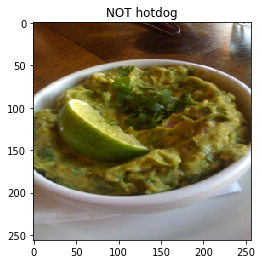

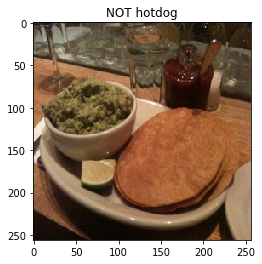

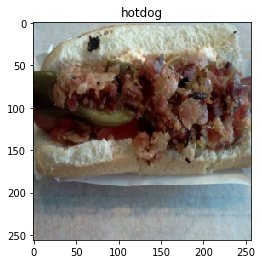

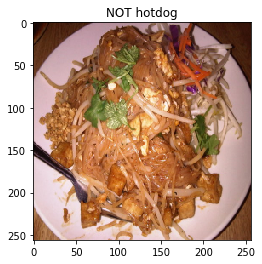

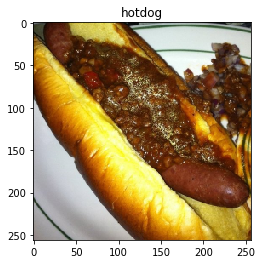

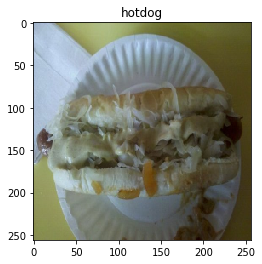

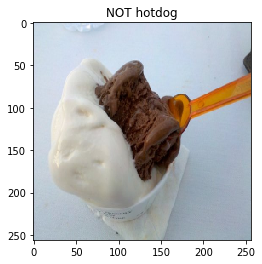

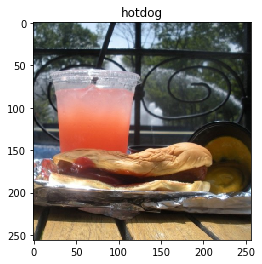

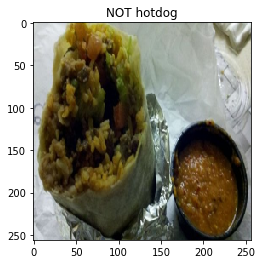

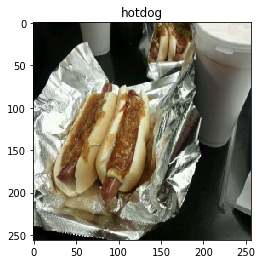

In [31]:
for i in range(10):
    image = np.uint8(X_test[i]*255)
    
    plt.title('NOT hotdog' if y_pred_labels[i] == 0 else 'hotdog')
    plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB)) 
    plt.show()